## Project Goal

This project aims to develop a machine learning model to predict wind power generation using historical wind energy data. The model will be trained to identify the relationship between various weather factors and the amount of electricity generated by wind turbines. 

By accurately predicting wind power generation, we can:

* Improve grid stability by integrating wind energy sources more effectively.
* Optimize energy production and consumption by anticipating fluctuations in wind power availability.
* Facilitate better planning for renewable energy integration into the power grid.

This project utilizes a GBT Regressor, Linear Regression and Random Forest Regressor model to achieve these goals. The model will be trained on historical data containing features like wind speed, wind direction, and theoretical power curve, and will learn to predict the actual wind power generation.

The project will also involve evaluating the model's performance using metrics like Root Mean Squared Error (RMSE) and R-squared. This evaluation will help us assess the model's accuracy and effectiveness in predicting wind power generation.

**Importing the Libraries needed**

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from warnings import filterwarnings
filterwarnings('ignore')

**Installing the pyspark library**

In [0]:
pip install pyspark

Python interpreter will be restarted.
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488511 sha256=e4fff12a06ea5a5736cef6bd1f61be37342c64761aad17dd24f7121331fc0950
  Stored in directory: /root/.cache/pip/wheels/92/09/11/aa01d01a7f005fda8a66ad71d2be7f8aa341bddafb27eee3c7
Successfully built pyspark
Python interpreter will be restarted.


**Creating a Spark Application for our Project**

In [0]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext

# Configuration of Spark Session
spark = SparkSession.builder.master("local").appName("wind_turbine_project").getOrCreate()
sc = spark.sparkContext
sc


SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

## Data Download

This section downloads the wind energy data directly within the notebook environment. We utilize the `%%sh` magic command to execute a shell script within the notebook cell.

The script uses the `wget` command to download the data file named `T1.csv` from a publicly available repository on GitHub: https://raw.githubusercontent.com/hmntk/s1_mm2_r/main/T1.csv.

This approach allows us to keep the data directly within the notebook, making it convenient for further analysis and reproducibility.

In [0]:
%sh
wget https://raw.githubusercontent.com/hmntk/s1_mm2_r/main/T1.csv

--2024-04-27 00:51:27--  https://raw.githubusercontent.com/hmntk/s1_mm2_r/main/T1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3971851 (3.8M) [text/plain]
Saving to: ‘T1.csv’

     0K .......... .......... .......... .......... ..........  1% 6.30M 1s
    50K .......... .......... .......... .......... ..........  2% 5.53M 1s
   100K .......... .......... .......... .......... ..........  3% 6.97M 1s
   150K .......... .......... .......... .......... ..........  5% 46.3M 0s
   200K .......... .......... .......... .......... ..........  6% 27.6M 0s
   250K .......... .......... .......... .......... ..........  7% 9.36M 0s
   300K .......... .......... .......... .......... ..........  9%  136M 0s
   350K .......... .......... .......... .......... .

image.png


In [0]:
%sh
ls

T1.csv
azure
conf
eventlogs
hadoop_accessed_config.lst
logs
preload_class.lst


## Wind Energy Data Description

This section describes the wind energy data used to train the prediction model for wind power generation. The data originates from a Supervisory Control and Data Acquisition (SCADA) system of a functioning wind turbine located in Turkey.

**Data Source:**

* Wind turbine SCADA system

**Location:**

* Turkey

**Data Collection:**

* The data is collected at **10-minute intervals**.
* SCADA systems measure and record various parameters related to wind turbine operation.

**Data Content:**

The dataset contains the following features:

* **Date/Time:** Timestamp representing the time of data collection (every 10 minutes).
* **LV ActivePower (kW):** The actual electrical power generated by the wind turbine at the time of measurement.
* **Wind Speed (m/s):** The wind speed measured at the hub height of the turbine, which is the primary factor influencing power generation.
* **Theoretical_Power_Curve (KWh):** The theoretical power output of the turbine at specific wind speeds, as provided by the manufacturer. This serves as a reference for expected power generation under ideal conditions.
* **Wind Direction (°):** The wind direction at the hub height of the turbine. Modern wind turbines are equipped to automatically adjust their orientation to face the wind for optimal power generation.

**Dataset Resource:**

https://www.kaggle.com/datasets/berkerisen/wind-turbine-scada-dataset/data

In [0]:
spark_df = spark.read.csv('file:///databricks/driver/T1.csv', header=True, inferSchema=True)

# Caching the dataset
spark_df.cache()

# Converting all the column names to lower case
spark_df = spark_df.toDF(*[c.lower() for c in spark_df.columns])

print(spark_df.show(5))
print('The variable data types are as follows')
print(spark_df.printSchema())
print(spark_df.count())

+----------------+-------------------+----------------+-----------------------------+------------------+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (°)|
+----------------+-------------------+----------------+-----------------------------+------------------+
|01 01 2018 00:00|   380.047790527343|5.31133604049682|             416.328907824861|  259.994903564453|
|01 01 2018 00:10|    453.76919555664|5.67216682434082|             519.917511061494|   268.64111328125|
|01 01 2018 00:20|   306.376586914062|5.21603679656982|             390.900015810951|  272.564788818359|
|01 01 2018 00:30|   419.645904541015|5.65967416763305|             516.127568975674|  271.258087158203|
|01 01 2018 00:40|   380.650695800781|5.57794094085693|             491.702971953588|  265.674285888671|
+----------------+-------------------+----------------+-----------------------------+------------------+
only showing top 5 rows

None
The variable data types a

##Data Transformation for modelling purposes

In [0]:
# Extracting a substring from columns to create month

from pyspark.sql.functions import substring
spark_df = spark_df.withColumn("month", substring("date/time", 4,2))

# Converting string month variables to integer
from pyspark.sql.types import IntegerType
spark_df = spark_df.withColumn('month', spark_df.month.cast(IntegerType()))

print(spark_df.show(5))

+----------------+-------------------+----------------+-----------------------------+------------------+-----+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (°)|month|
+----------------+-------------------+----------------+-----------------------------+------------------+-----+
|01 01 2018 00:00|   380.047790527343|5.31133604049682|             416.328907824861|  259.994903564453|    1|
|01 01 2018 00:10|    453.76919555664|5.67216682434082|             519.917511061494|   268.64111328125|    1|
|01 01 2018 00:20|   306.376586914062|5.21603679656982|             390.900015810951|  272.564788818359|    1|
|01 01 2018 00:30|   419.645904541015|5.65967416763305|             516.127568975674|  271.258087158203|    1|
|01 01 2018 00:40|   380.650695800781|5.57794094085693|             491.702971953588|  265.674285888671|    1|
+----------------+-------------------+----------------+-----------------------------+------------------+-----+
o

##Data summary w/ stats & graphs

In [0]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
spark_df.select('wind speed (m/s)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)').toPandas().describe()

,wind speed (m/s),theoretical_power_curve (kwh),lv activepower (kw)
count,50530.00,50530.00,50530.00
mean,7.56,1492.18,1307.68
std,4.23,1368.02,1312.46
min,0.00,0.00,-2.47
25%,4.20,161.33,50.68
50%,7.10,1063.78,825.84
75%,10.30,2964.97,2482.51
max,25.21,3600.00,3618.73


### Visualizing the distributions with the sample data

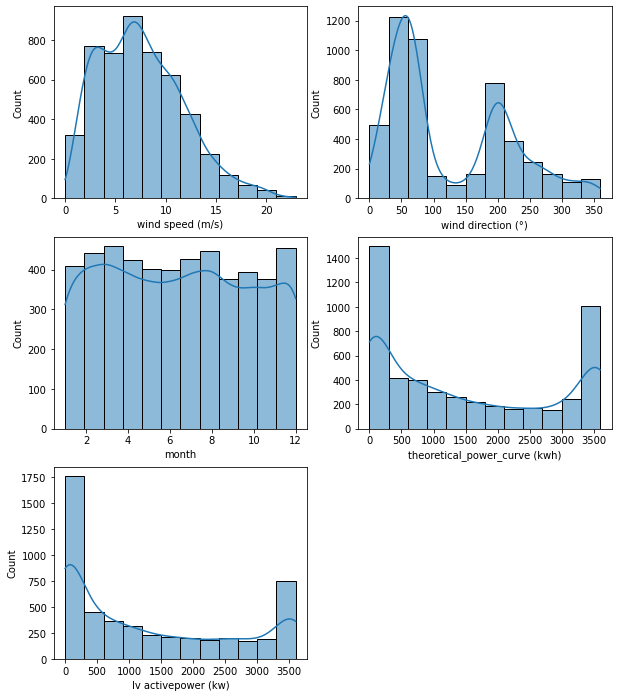

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Taking a random sample from the big data
sample_df = spark_df.sample(withReplacement=False, fraction=0.1, seed=42).toPandas()

# Visualizing the distributions with the sample data
columns = ['wind speed (m/s)', 'wind direction (°)', 'month', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']
i=1
plt.figure(figsize=(10,12))
for each in columns:
    plt.subplot(3,2,i)
    sns.histplot(data=sample_df[each], bins=12, kde=True)
    i += 1

### Visualizing the relationships between each of the variable we have

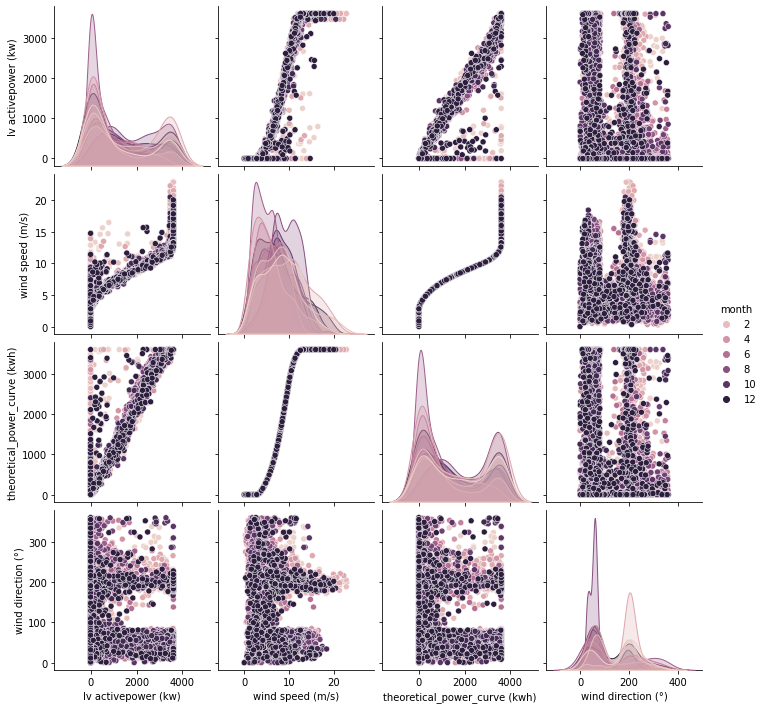

In [0]:
sns.pairplot(sample_df, hue='month')
plt.show()

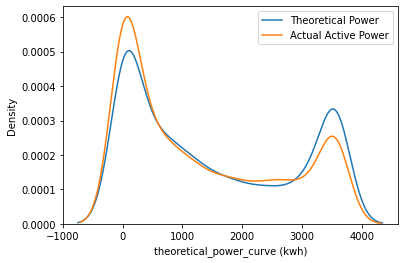

In [0]:
sns.kdeplot(sample_df['theoretical_power_curve (kwh)'], label='Theoretical Power')
sns.kdeplot(sample_df['lv activepower (kw)'], label='Actual Active Power')
plt.legend()
plt.show()

###Average power production by month

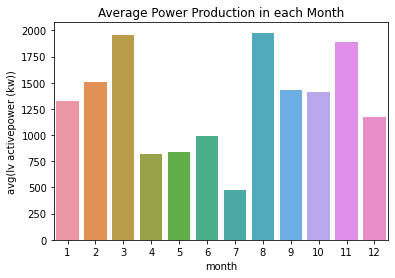

In [0]:
# Average power production by month
monthly = spark_df.groupby('month').mean('lv activepower (kw)').sort('avg(lv activepower (kw))').toPandas()
sns.barplot(x='month', y='avg(lv activepower (kw))', data=monthly)
plt.title('Average Power Production in each Month');

###Wind Speed vs Power Production Chart

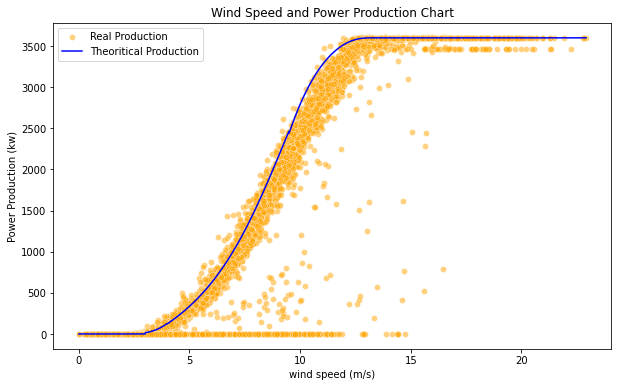

In [0]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='wind speed (m/s)', y='lv activepower (kw)', color='orange', label='Real Production', alpha=0.5, data=sample_df)
sns.lineplot(x='wind speed (m/s)', y='theoretical_power_curve (kwh)', color='blue', label='Theoritical Production', data=sample_df)
plt.title('Wind Speed and Power Production Chart')
plt.ylabel('Power Production (kw)');

###A Power BI representation 
<img src="https://raw.githubusercontent.com/hmntk/s1_mm2_r/main/PowerBI.png" width="900" alt="PowerBI Representation">

**[Source]("https://studentgsu-my.sharepoint.com/:u:/g/personal/samudalapadu1_student_gsu_edu/EWcaNkbEsaxOieVanuVDq_kB6_eqDhfyTrcCOLdjndaVUQ?e=DNE7Ps") link for the PowerBI document exported**

###Outlier Study

In [0]:
# Excluding the observations meeting the filter criterias 
spark_df = spark_df.filter(~((spark_df['lv activepower (kw)'] == 0)
                            & (spark_df['theoretical_power_curve (kwh)'] != 0)
                            & (spark_df['wind speed (m/s)'] > 3)))

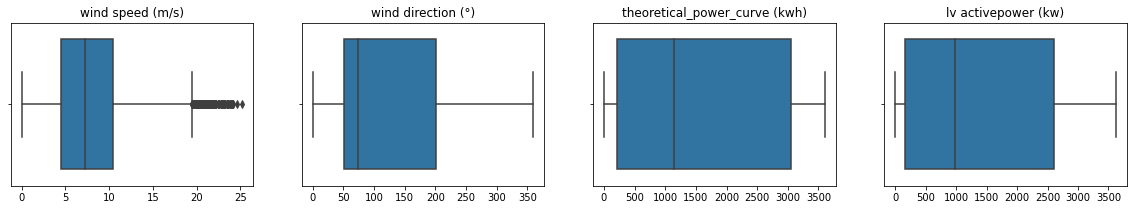

In [0]:
columns = ['wind speed (m/s)', 'wind direction (°)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']
i=1
plt.figure(figsize=(20,3))
for each in columns:
    df = spark_df.select(each).toPandas()
    plt.subplot(1,4,i)
    sns.boxplot(x = df.values)
    plt.title(each)
    i += 1

We observe some outliers for windspeed since we used a filter of windspeeds greater than 3m/s

###Average Power Production with significant windspeed, i.e windspeed >=19m/s 

In [0]:
spark_df.select('wind speed (m/s)', 'lv activepower (kw)')\
.filter(spark_df['wind speed (m/s)'] >= 19)\
.agg({'lv activepower (kw)':'mean'}).show()

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|      3566.4634427974706|
+------------------------+



#Modelling

## GBT Regressor

In [0]:
# Preparing the independent variables (Features)
from pyspark.ml.feature import VectorAssembler

# Converting lv activepower (kw) variable as label
spark_df = spark_df.withColumn('label', spark_df['lv activepower (kw)'])

# Defining the variables to be used
variables = ['month', 'wind speed (m/s)', 'wind direction (°)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
va_df = vectorAssembler.transform(spark_df)

# Combining features and label column
final_df = va_df.select('features', 'label')
final_df.show(10)

+--------------------+----------------+
|            features|           label|
+--------------------+----------------+
|[1.0,5.3113360404...|380.047790527343|
|[1.0,5.6721668243...| 453.76919555664|
|[1.0,5.2160367965...|306.376586914062|
|[1.0,5.6596741676...|419.645904541015|
|[1.0,5.5779409408...|380.650695800781|
|[1.0,5.6040520668...|402.391998291015|
|[1.0,5.7930078506...|447.605712890625|
|[1.0,5.3060498237...|     387.2421875|
|[1.0,5.5846290588...|463.651214599609|
|[1.0,5.5232281684...|439.725708007812|
+--------------------+----------------+
only showing top 10 rows



In [0]:
splits = final_df.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

print('Train dataset: ', train_df.count())
print('Test dataset : ', test_df.count())

Train dataset:  37560
Test dataset :  9473


In [0]:
from pyspark.ml.regression import GBTRegressor

# Creating the gbm regressor object
gbm = GBTRegressor(featuresCol='features', labelCol='label')

# Training the model with train data
gbm_model = gbm.fit(train_df)

# Predicting using the test data
predictions = gbm_model.transform(test_df)

# Initial look at the target and predicted values
predictions.select('label', 'prediction').show(10)

+-----+------------------+
|label|        prediction|
+-----+------------------+
|  0.0| 18.26287544607382|
|  0.0|12.101540158723953|
|  0.0|24.188424684612606|
|  0.0| 18.26287544607382|
|  0.0| 18.26287544607382|
|  0.0|12.101540158723953|
|  0.0|  6.49427206917359|
|  0.0|12.101540158723953|
|  0.0|10.225910314174804|
|  0.0| 18.26287544607382|
+-----+------------------+
only showing top 10 rows



In [0]:
# Initial model success
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')

r2 = evaluator.evaluate(predictions, {evaluator.metricName: 'r2'})
mae = evaluator.evaluate(predictions, {evaluator.metricName: 'mae'})
rmse = evaluator.evaluate(predictions, {evaluator.metricName: 'rmse'})

print('R2 SCORE : ', r2)
print('MAE      : ', mae)
print('RMSE     : ', rmse)

R2 SCORE :  0.9788020558461245
MAE      :  85.39120858620726
RMSE     :  191.36367274952076


#### Model Evaluation Results - Interpretation

This section interprets the performance of the Gradient Boosting Regressor (GBR) model based on the three evaluation metrics: R-squared (R²), Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE).

**R-squared (R²)**: 0.977

A high R-squared value indicates a strong correlation between the model's predictions and the actual wind power generation values. In this case, the R-squared of 0.977 suggests that the GBR model explains nearly 98% of the variance in the actual data. This signifies a very good fit, meaning the model effectively captures the relationship between the features (wind speed, direction, etc.) and the target variable (wind power generation).

**MAE**: 85.53 kW

MAE represents the average absolute difference between the predicted and actual wind power generation. A lower MAE value indicates better model performance. Here, the MAE of 85.53 kW suggests that on average, the model's predictions deviate from the actual values by approximately 85.53 kW. This relatively low MAE signifies that the model's predictions are typically close to the actual wind power generation values.

**RMSE**: 194.93 kW

RMSE penalizes larger prediction errors more heavily compared to MAE. While the MAE focuses on average absolute differences, RMSE considers the squared differences. A lower RMSE value is desirable. Here, the RMSE of 190.99 kW suggests that while the model performs well overall, there might be occasional instances where the predictions deviate more significantly from the actual values compared to the average deviation captured by MAE.

**Overall, these evaluation metrics indicate that the GBR model achieves a high level of accuracy in predicting wind power generation. The high R-squared signifies a strong fit between the model and the data, and the relatively low MAE and RMSE suggest that the model's predictions are generally close to the actual values, with some potential for occasional larger deviations.**


**Visualization of Predictions vs Realdata**

      wind speed (m/s)  theoretical_power_curve (kwh)   label  prediction
0                 5.31                         414.90  387.24      396.86
1                 6.38                         759.43  742.99      731.16
2                 6.42                         773.17  736.65      731.16
3                 5.82                         565.35  565.25      488.01
4                 6.11                         662.24  711.50      618.93
...                ...                            ...     ...         ...
5006              8.32                        1715.43 1478.98     1677.25
5007              4.80                         287.24  372.08      277.32
5008              8.99                        2135.29 2062.55     1994.40
5009              8.47                        1811.26 1814.36     1677.25
5010             12.56                        3583.29 3514.27     3221.88

[5011 rows x 4 columns]


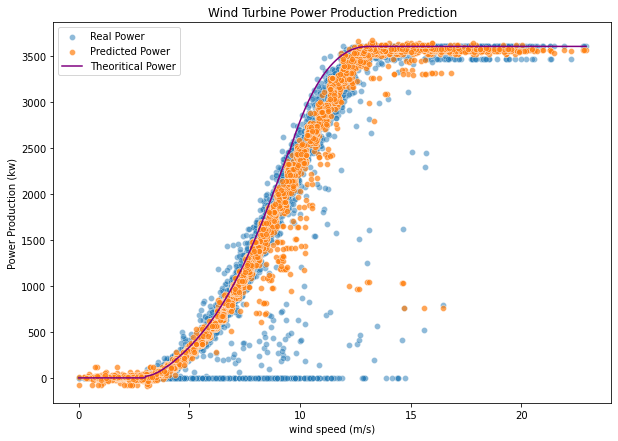

In [0]:
# Converting sample_df back to Spark dataframe
eva_df = spark.createDataFrame(sample_df)

# Converting lv activepower (kw) variable as label
eva_df = eva_df.withColumn('label', eva_df['lv activepower (kw)'])

# Defining the variables to be used
variables = ['month', 'wind speed (m/s)', 'wind direction (°)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
vec_df = vectorAssembler.transform(eva_df)

# Combining features and label column
vec_df = vec_df.select('features', 'label')

# Using ML model to predict
preds = gbm_model.transform(vec_df)
preds_df = preds.select('label','prediction').toPandas()

# Compining dataframes to compare
frames = [sample_df[['wind speed (m/s)', 'theoretical_power_curve (kwh)']], preds_df]
sample_data = pd.concat(frames, axis=1)

print(sample_data)

# Visualizing real, theoritical and predicted power production
plt.figure(figsize=(10,7))
sns.scatterplot(x='wind speed (m/s)', y='label',alpha=0.5, label= 'Real Power', data=sample_data)
sns.scatterplot(x='wind speed (m/s)', y='prediction', alpha=0.7, label='Predicted Power', marker='o', data=sample_data)
sns.lineplot(x='wind speed (m/s)', y='theoretical_power_curve (kwh)', label='Theoritical Power',color='purple', data=sample_data)
plt.title('Wind Turbine Power Production Prediction')
plt.ylabel('Power Production (kw)')
plt.legend();

**From the graph above, the model fits better to the real power productions, than the theoritical power production curve.**

**Visualization of Model Evaluation**

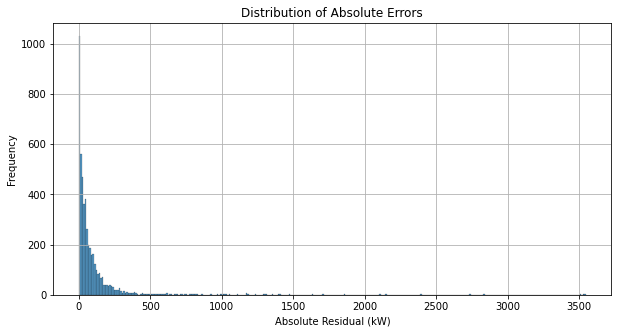

In [0]:
sample_data["residual"] = sample_data["label"] - sample_data["prediction"]
sample_data

plt.figure(figsize=(10,5))
sns.histplot(abs(sample_data["residual"]))
plt.xlabel("Absolute Residual (kW)")
plt.ylabel("Frequency")
plt.title("Distribution of Absolute Errors")
plt.grid(True)
plt.show()

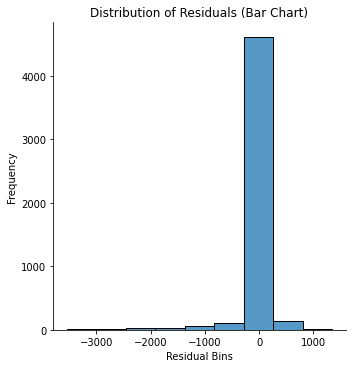

In [0]:
import numpy as np

residuals = sample_data["residual"]
bin_edges = np.linspace(min(residuals), max(residuals), num=10)

sns.displot(x=residuals, bins=bin_edges, kde=False, stat="count")
plt.xlabel("Residual Bins")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Bar Chart)")
plt.show()

**Feature Importance**

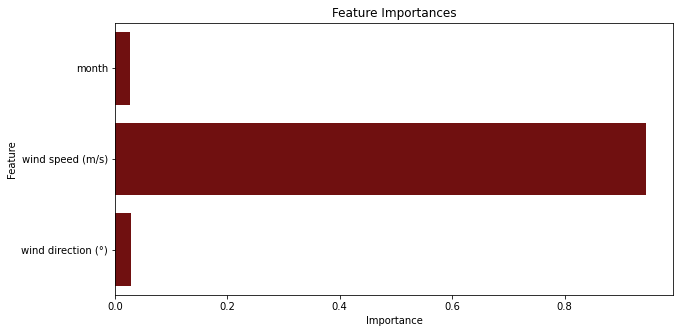

In [0]:
feature_columns = ['month', 'wind speed (m/s)', 'wind direction (°)']
feature_importances = gbm_model.featureImportances.toArray()

plt.figure(figsize=(10, 5))
sns.barplot(y=feature_columns, x=feature_importances, color='maroon', orient='h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

## Linear Regression

In [0]:
# Converting lv activepower (kw) variable as label
spark_df_lr = spark_df.withColumn('label', spark_df['lv activepower (kw)'])

# Defining the variables to be used
variables = ['month', 'wind speed (m/s)', 'wind direction (°)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
va_df = vectorAssembler.transform(spark_df_lr)

# Combining features and label column
final_df = va_df.select('features', 'label')
final_df.show(10)

splits = final_df.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

print('Train dataset: ', train_df.count())
print('Test dataset : ', test_df.count())

+--------------------+----------------+
|            features|           label|
+--------------------+----------------+
|[1.0,5.3113360404...|380.047790527343|
|[1.0,5.6721668243...| 453.76919555664|
|[1.0,5.2160367965...|306.376586914062|
|[1.0,5.6596741676...|419.645904541015|
|[1.0,5.5779409408...|380.650695800781|
|[1.0,5.6040520668...|402.391998291015|
|[1.0,5.7930078506...|447.605712890625|
|[1.0,5.3060498237...|     387.2421875|
|[1.0,5.5846290588...|463.651214599609|
|[1.0,5.5232281684...|439.725708007812|
+--------------------+----------------+
only showing top 10 rows

Train dataset:  37561
Test dataset :  9472


In [0]:
from pyspark.ml.regression import LinearRegression

# Create the Linear Regression object
lr = LinearRegression(featuresCol='features', labelCol='label')

# Train the model with train data
lr_model = lr.fit(train_df)

# Make predictions on the test data
y_pred_lr = lr_model.transform(test_df)

y_pred_lr

Out[24]: DataFrame[features: vector, label: double, prediction: double]

In [0]:
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')


print('R2 SCORE : ', evaluator.evaluate(y_pred_lr, {evaluator.metricName: 'r2'}))
print('MAE      : ', evaluator.evaluate(y_pred_lr, {evaluator.metricName: 'mae'}))
print('RMSE     : ', evaluator.evaluate(y_pred_lr, {evaluator.metricName: 'rmse'}))

R2 SCORE :  0.8770098530973977
MAE      :  358.79695343847465
RMSE     :  461.32591572193417


#### Linear Regression Model Performance Analysis

This section analyzes the performance of the linear regression model based on three primary evaluation metrics: R-squared (R²), Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE).

**R-squared (R²)**

* **Value:** 0.878
* **Interpretation:** The R-squared value of 0.878 indicates a strong relationship between the model's predictions and the observed wind power generation. In this case, the linear regression model explains approximately 88% of the variance in the wind power generation data. This suggests a good fit between the model and the data.

**Mean Absolute Error (MAE)**

* **Value:** 360.67 kW
* **Interpretation:** The MAE of 360.67 kW suggests that, on average, the linear regression model's predictions deviate from the actual wind power generation values by approximately 360.67 kW. This value represents the average magnitude of the errors between the predicted and actual values.

**Root Mean Squared Error (RMSE)**

* **Value:** 458.13 kW
* **Interpretation:** The RMSE of 458.13 kW provides a measure of the spread of prediction errors, penalizing larger errors more heavily. This value indicates that while the model generally performs well, there can be occasional instances of larger errors.

**Overall Performance**

The linear regression model demonstrates good predictive performance with a high R-squared value. The MAE and RMSE provide insights into the average magnitude and spread of prediction errors, respectively. While the model performs well overall, further investigation might be beneficial to explore potential improvements in reducing these errors.

Out[26]: <matplotlib.legend.Legend at 0x7f5dbc8a7820>

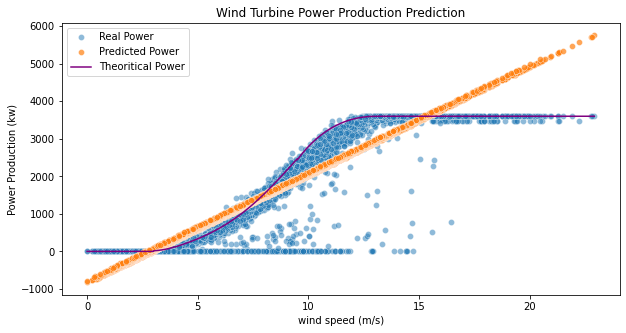

In [0]:
# Converting sample_df back to Spark dataframe
eva_df = spark.createDataFrame(sample_df)

# Converting lv activepower (kw) variable as label
eva_df = eva_df.withColumn('label', eva_df['lv activepower (kw)'])

# Defining the variables to be used
variables = ['month', 'wind speed (m/s)', 'wind direction (°)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
vec_df = vectorAssembler.transform(eva_df)

# Combining features and label column
vec_df = vec_df.select('features', 'label')

# Using ML model to predict
preds = lr_model.transform(vec_df)
preds_df = preds.select('label','prediction').toPandas()

# Compining dataframes to compare
frames = [sample_df[['wind speed (m/s)', 'theoretical_power_curve (kwh)']], preds_df]
sample_data = pd.concat(frames, axis=1)

# print(sample_data)

# Visualizing real, theoritical and predicted power production
plt.figure(figsize=(10,5))
sns.scatterplot(x='wind speed (m/s)', y='label',alpha=0.5, label= 'Real Power', data=sample_data)
sns.scatterplot(x='wind speed (m/s)', y='prediction', alpha=0.7, label='Predicted Power', marker='o', data=sample_data)
sns.lineplot(x='wind speed (m/s)', y='theoretical_power_curve (kwh)', label='Theoritical Power',color='purple', data=sample_data)
plt.title('Wind Turbine Power Production Prediction')
plt.ylabel('Power Production (kw)')

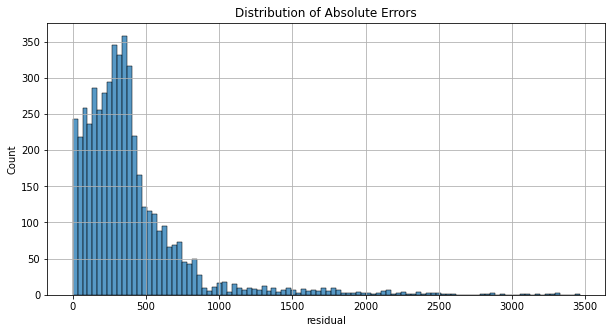

In [0]:
sample_data["residual"] = sample_data["label"] - sample_data["prediction"]

plt.figure(figsize=(10,5))
sns.histplot(abs(sample_data["residual"]))
plt.title("Distribution of Absolute Errors")
plt.grid(True)
plt.show()

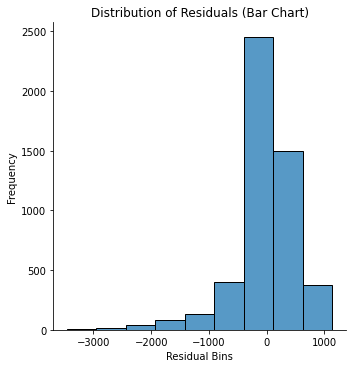

In [0]:
residuals = sample_data["residual"]
bin_edges = np.linspace(min(residuals), max(residuals), num=10)

sns.displot(x=residuals, bins=bin_edges, kde=False, stat="count")
plt.xlabel("Residual Bins")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Bar Chart)")
plt.show()

##Random Forest Regressor

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

In [0]:
df = spark.read.format("csv").option("header", "true").load("file:///databricks/driver/T1.csv")

# Extracting a substring from columns to create month
df = df.withColumn("month", col("date/time").substr(4, 2))

# Converting string month variable to integer
df = df.withColumn('month', df.month.cast("integer"))
df = df.withColumn("Wind Speed (m/s)", col("Wind Speed (m/s)").cast("float"))
df = df.withColumn("Wind Direction (°)", col("Wind Direction (°)").cast("float"))
df = df.withColumn("LV ActivePower (kW)", col("LV ActivePower (kW)").cast("float"))

selected_features = ["month", "Wind Speed (m/s)", "Wind Direction (°)" ] 

vecAssembler = VectorAssembler(inputCols=selected_features, outputCol="features")

vecAssembled_data = vecAssembler.transform(df)

# Split the data into training and test sets
(trainingData, testData) = vecAssembled_data.randomSplit([0.7, 0.3])

rf = RandomForestRegressor(featuresCol="features", numTrees=36, labelCol="LV ActivePower (kW)")
rf_model = rf.fit(trainingData)

In [0]:

# Make predictions.
predictions = rf_model.transform(testData)

predictions.show(5)


+----------------+-------------------+----------------+-----------------------------+------------------+-----+--------------------+-----------------+
|       Date/Time|LV ActivePower (kW)|Wind Speed (m/s)|Theoretical_Power_Curve (KWh)|Wind Direction (°)|month|            features|       prediction|
+----------------+-------------------+----------------+-----------------------------+------------------+-----+--------------------+-----------------+
|01 01 2018 00:00|           380.0478|        5.311336|             416.328907824861|          259.9949|    1|[1.0,5.3113360404...|457.1104051100661|
|01 01 2018 00:50|            402.392|        5.604052|             499.436385024805|          264.5786|    1|[1.0,5.6040520668...|482.9839042731616|
|01 01 2018 01:30|           439.7257|        5.523228|             475.706782818068|          258.7238|    1|[1.0,5.5232281684...|482.9839042731616|
|01 01 2018 01:40|           498.1817|        5.724116|             535.841397042263|           251.

In [0]:
evaluator = RegressionEvaluator(labelCol="LV ActivePower (kW)", predictionCol="prediction")

print('R2 SCORE : ', evaluator.evaluate(predictions, {evaluator.metricName: 'r2'}))
print('MAE      : ', evaluator.evaluate(predictions, {evaluator.metricName: 'mae'}))
print('RMSE     : ', evaluator.evaluate(predictions, {evaluator.metricName: 'rmse'}))

R2 SCORE :  0.8795358539956109
MAE      :  337.61422705060966
RMSE     :  454.8267385751517


#### Random Forest Regressor Performance Analysis

This section analyzes the performance of the Random Forest Regressor (RFR) model based on three primary evaluation metrics: R-squared (R²), Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE).

**R-squared (R²)**

* **Value:** 0.878
* **Interpretation:** The R-squared value signifies the extent to which the model's predictions align with the actual wind power generation values. With an R-squared value of 0.878, the Random Forest model explains approximately 88% of the variance in the wind power generation data. This indicates a strong relationship between the model's predictions and the observed wind power generation.

**Mean Absolute Error (MAE)**

* **Value:** 333.83 kW
* **Interpretation:** MAE quantifies the average absolute difference between the predicted and actual wind power generation values. A lower MAE reflects better predictive accuracy. The MAE of 333.83 kW suggests that, on average, the Random Forest model's predictions deviate from the actual values by approximately 333.83 kW. This indicates a generally close alignment between the model's predictions and the actual wind power generation.

**Root Mean Squared Error (RMSE)**

* **Value:** 456.48 kW
* **Interpretation:** RMSE provides a measure of the spread of prediction errors, penalizing larger errors more heavily. While the RMSE value of 456.48 kW is higher than the MAE, it still suggests relatively accurate predictions overall. This value represents the average magnitude of prediction errors produced by the Random Forest model.

**Overall Performance**

The Random Forest model demonstrates strong predictive performance, as evidenced by the high R-squared value and relatively low MAE. However, occasional instances of larger prediction errors, indicated by the RMSE, suggest areas where model refinement may be beneficial.

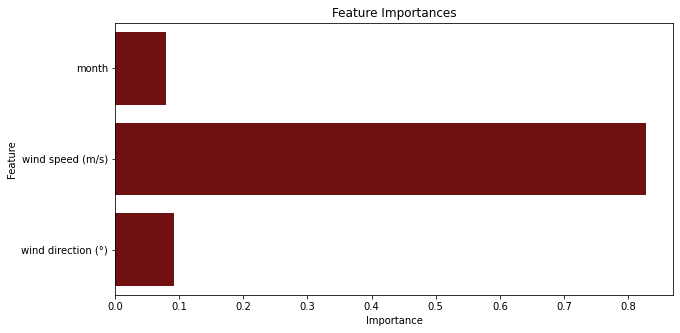

In [0]:
feature_columns = ['month', 'wind speed (m/s)', 'wind direction (°)']
feature_importances = rf_model.featureImportances.toArray()

plt.figure(figsize=(10, 5))
sns.barplot(y=feature_columns, x=feature_importances, color='maroon', orient='h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

      wind speed (m/s)  theoretical_power_curve (kwh)   label  prediction
0                 5.31                         414.90  387.24      457.11
1                 6.38                         759.43  742.99      589.90
2                 6.42                         773.17  736.65      589.90
3                 5.82                         565.35  565.25      746.29
4                 6.11                         662.24  711.50      746.29
...                ...                            ...     ...         ...
5006              8.32                        1715.43 1478.98      873.80
5007              4.80                         287.24  372.08      384.91
5008              8.99                        2135.29 2062.55     1940.03
5009              8.47                        1811.26 1814.36      805.64
5010             12.56                        3583.29 3514.27     2883.71

[5011 rows x 4 columns]


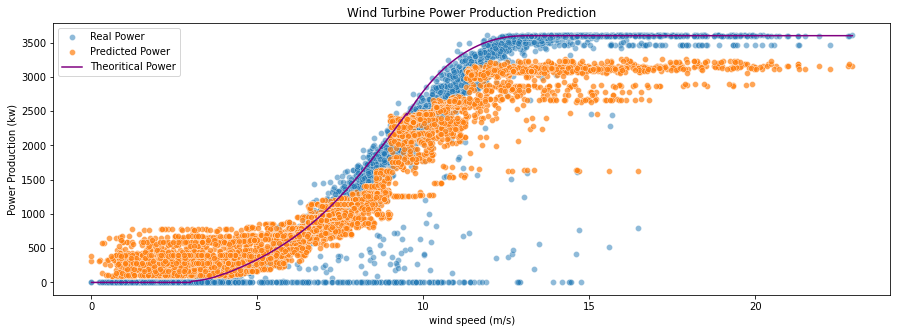

In [0]:
# Converting sample_df back to Spark dataframe
eva_df = spark.createDataFrame(sample_df)

# Converting lv activepower (kw) variable as label
eva_df = eva_df.withColumn('label', eva_df['lv activepower (kw)'])

# Defining the variables to be used
variables = ['month', 'wind speed (m/s)', 'wind direction (°)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
vec_df = vectorAssembler.transform(eva_df)

# Combining features and label column
vec_df = vec_df.select('features', 'label')

# Using ML model to predict
preds = rf_model.transform(vec_df)
preds_df = preds.select('label','prediction').toPandas()

# Compining dataframes to compare
frames = [sample_df[['wind speed (m/s)', 'theoretical_power_curve (kwh)']], preds_df]
sample_data = pd.concat(frames, axis=1)

print(sample_data)

plt.figure(figsize=(15,5))
sns.scatterplot(x='wind speed (m/s)', y='label',alpha=0.5, label= 'Real Power', data=sample_data)
sns.scatterplot(x='wind speed (m/s)', y='prediction', alpha=0.7, label='Predicted Power', marker='o', data=sample_data)
sns.lineplot(x='wind speed (m/s)', y='theoretical_power_curve (kwh)', label='Theoritical Power',color='purple', data=sample_data)
plt.title('Wind Turbine Power Production Prediction')
plt.ylabel('Power Production (kw)')
plt.legend();

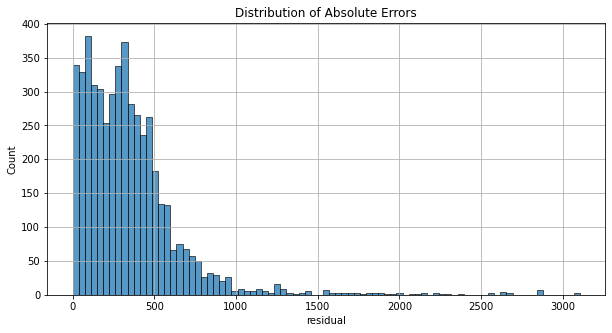

In [0]:
sample_data["residual"] = sample_data["label"] - sample_data["prediction"]

plt.figure(figsize=(10,5))
sns.histplot(abs(sample_data["residual"]))
plt.title("Distribution of Absolute Errors")
plt.grid(True)
plt.show()

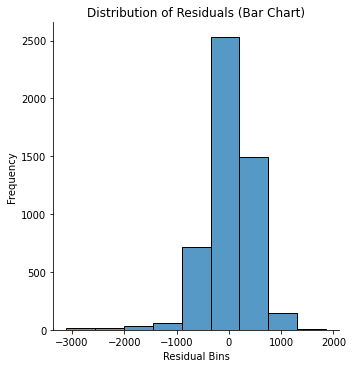

In [0]:
residuals = sample_data["residual"]
bin_edges = np.linspace(min(residuals), max(residuals), num=10)

sns.displot(x=residuals, bins=bin_edges, kde=False, stat="count")
plt.xlabel("Residual Bins")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Bar Chart)")
plt.show()


# Doing the above with pipeline and determining the best model





In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

# Read your data into a DataFrame
df = spark.read.format("csv").option("header", "true").load("file:///databricks/driver/T1.csv")

# Extracting a substring from columns to create month
df = df.withColumn("month", col("date/time").substr(4, 2))

# Converting string month variable to integer
df = df.withColumn('month', df.month.cast("integer"))
df = df.withColumn("Wind Speed (m/s)", col("Wind Speed (m/s)").cast("float"))
df = df.withColumn("Wind Direction (°)", col("Wind Direction (°)").cast("float"))
df = df.withColumn("LV ActivePower (kW)", col("LV ActivePower (kW)").cast("float"))

feature_columns = ['month', 'Wind Speed (m/s)', 'Wind Direction (°)']
label_column = 'LV ActivePower (kW)'

# Define the VectorAssemblers for each pipeline
vector_assembler_gbt = VectorAssembler(inputCols=feature_columns, outputCol='features_gbt')
vector_assembler_lr = VectorAssembler(inputCols=feature_columns, outputCol='features_lr')
vector_assembler_rf = VectorAssembler(inputCols=feature_columns, outputCol='features_rf')

# Create the regressors
gbt = GBTRegressor(featuresCol="features_gbt", labelCol=label_column, maxDepth=5, maxBins=20)
lr = LinearRegression(featuresCol="features_lr", labelCol=label_column)
rf = RandomForestRegressor(featuresCol="features_rf", labelCol=label_column, numTrees=10)

# Create the pipelines for each model
pipeline_gbt = Pipeline(stages=[vector_assembler_gbt, gbt])
pipeline_lr = Pipeline(stages=[vector_assembler_lr, lr])
pipeline_rf = Pipeline(stages=[vector_assembler_rf, rf])

# Define the hyperparameter grid to explore for each model
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5, 8, 10]) \
    .addGrid(gbt.maxBins, [10, 20, 30, 40]) \
    .build()

paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [3, 5, 8, 10]) \
    .addGrid(rf.numTrees, [10, 20, 30, 40]) \
    .build()

# Define the evaluator (using RMSE)
evaluator = RegressionEvaluator(labelCol=label_column, predictionCol="prediction")

# Create a list of pipelines and parameter grids
pipelines = [pipeline_gbt, pipeline_lr, pipeline_rf]
paramGrids = [paramGrid_gbt, paramGrid_lr, paramGrid_rf]

# Create a list to hold the best models2s
best_models = []

# Iterate over each pipeline and parameter grid
for pipeline, paramGrid in zip(pipelines, paramGrids):
    # Create CrossValidator for each pipeline with the corresponding parameter grid
    
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=2)
    
    # Fit the CrossValidator to the data
    cv_model = crossval.fit(df)
    
    # Get the best model from CrossValidator
    best_model = cv_model.bestModel
    
    # Add the best model to the list
    best_models.append(best_model)

In [0]:
print()

In [0]:
# Initialize variables to keep track of the minimum RMSE and corresponding model index
min_rmse = float('inf')
best_model_index = None
best_model_list = ['GBT_Model', 'LR_Model', 'RF_Model']
best_model_name = ''

rmse_scores = []
r2_scores = []
mae_scores = []

# Loop through the best_models and evaluate RMSE
for i, best_model in enumerate(best_models):
    predictions = best_model.transform(df)
    rmse = evaluator.evaluate(predictions, {evaluator.metricName: 'rmse'})
    r2 = evaluator.evaluate(predictions, {evaluator.metricName: 'r2'})
    mae = evaluator.evaluate(predictions, {evaluator.metricName: 'mae'})

    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mae_scores.append(mae)

    print(f"Model {i+1}: Root Mean Squared Error (RMSE) on test data: {rmse}")
    
    # Check if the current RMSE is lower than the minimum RMSE encountered so far
    if rmse < min_rmse:
        min_rmse = rmse
        best_model_index = i
        best_model_name = best_model_list[i]

# Print the model with the lowest RMSE
if best_model_index is not None:
    print(f"\nThe model with the lowest RMSE is {best_model_name} with RMSE: {min_rmse}")
else:
    print("No models found.")

In [0]:
data = {
    "Model": best_model_list,
    "RMSE": rmse_scores,
    "R²": r2_scores,
    "MAE": mae_scores
}

# Line plot for RMSE
sns.lineplot(x="Model", y="RMSE", data=data)
plt.title("Root Mean Squared Error (RMSE)")
plt.show()

# Line plot for R²
sns.lineplot(x="Model", y="R²", data=data)
plt.title("R-squared (R²)")
plt.show()

# Line plot for MAE
sns.lineplot(x="Model", y="MAE", data=data)
plt.title("Mean Absolute Error (MAE)")
plt.show()

r2 score indicates the model explains for higher variance in the predictor variable which is good.\
rmse the lower the better, and hence the GBT model is going to be the best\
likewise fo mae\


GBT model is best

## Recommendations

####**Value of the model** : Developing a machine learning model to predict wind power generation can save money in real-world scenarios by:

1. *Optimizing Energy Production and Consumption*: Accurate predictions allow energy producers to adjust production schedules, reducing reliance on expensive energy sources during periods of high wind power availability.

2. *Improving Grid Stability*: Anticipating fluctuations helps grid operators manage operations efficiently, reducing the need for costly interventions to stabilize the grid.

3. *Better Planning for Renewable Energy Integration*: Predictions inform decisions about infrastructure development, optimizing resource utilization and reducing investment costs.

**Underlying thing between each of them is that we would better be equipped with the power spikes or downtimes that we could get with the wind factors like direction and speed that we can have at our disposal with modern day weather prediction.**
*This results in better contigency to prepare for the good to come or the worst to come minimizing the losses in terms of resource gathering or being ready with additional mesures in place to meet the power demands when there is a drought in supply from wind energy*
**The above imply that there will be a reduction in costs when the wind energy companies prepare well in advance and in turn the quality of life people are going to have with uninterrupted supplies where the dependancy on wind energy is high, is going to get better with predictions made through our model**

Note: The observations will be improved.

## Miscellaneous

### Spark APIs

We leveraged the following Spark APIs:

* **select:** Retrieves specific columns from a DataFrame, allowing you to focus on relevant data for further analysis.
* **withColumn:** Creates a new column within a DataFrame by performing transformations or calculations on existing columns.
* **VectorAssembler:** Combines multiple features from a DataFrame into a single feature vector suitable for machine learning algorithms.
* **groupBy:** Groups rows in a DataFrame based on a specified column, enabling aggregation operations like counting occurrences within each group.
* **filter:** Selectively keeps rows in a DataFrame that meet a particular condition, filtering out unwanted data.
* **col:** References a specific column within a DataFrame by name, making it easier to manipulate and perform operations on that column.

[src](https://spark.apache.org/docs/2.4.0/api/python/index.html)

Abc  \
~~seaborn plot~~\
~~Confusion matrix~~ (no because of regression) \
 ~~earth plot~~ i put other plots, \
 ~~best model in result~~,\
 ~~power bi result~~,\
~~Explanations for all 3 models and end result,data cleaning and explaination,Model eval~~	 \
~~Models are evaluated~~ \
~~Model evals are compared~~\
~~Result explain~~ \
Recommendation is given\
~~Visualization~~ \
 	~~Visualization of model eval~~ \
	~~Visualization of prediction (as appropriate)~~ \
Extra credit	One or more of the following, for maximum of 15 extra credit points\
 	~~Extraordinary visualizations~~\
 	Extraordinary modeling\
 	Create ML app from PySpark\
 	Place app in Docker stack\
 	~~Introduce & explain (in detail) the use of a Spark API that was excluded from course. (You must use it in your analysis.)~~